# Adult Census Income

## 0. Импорт необходимых библиотек

In [5]:
# Установка необходимых библиотек
# %pip install pandas
# %pip install catboost
# %pip install scikit-lear
# %pip install seaborn

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, RocCurveDisplay, PrecisionRecallDisplay

RANDOM_STATE = 42
plt.rcParams['figure.figsize'] = (10, 6)

## 1. EDA

Задача - бинарная классификация. Необходимо определить, получает ли человек годовой доход больше суммы N, или меньше.
Перед нами датасет Adult Census Income, имена и типы имеющихся признаков следующие.
Действительные (числовые) признаки:
<ol>
<li>age</li>
<li>final_weight</li>
<li>education-num</li>
<li>cap-gain</li>
<li>cap-loss</li>
<li>hours-per-week</li>
</ol>

Категориальные признаки:
<ol>
<li>workclass</li>
<li>education</li>
<li>marital-status</li>
<li>occupation</li>
<li>relationship</li>
<li>race</li>
<li>sex</li>
<li>native-country</li>
</ol>

Проведем базовый EDA.

In [7]:
# Прочитаем train датасет
names = ['age', 'workclass', 'final_weight', 'education', 'education-num', 'marital-status','occupation',
         'relationship', 'race','sex', 'cap-gain', 'cap-loss', 'hours-per-week', 'native-country']
numerical_features_names = ['age', 'final_weight', 'education-num', 'cap-gain', 'cap-loss', 'hours-per-week']
categorical_features_names = list(set(names) - set(numerical_features_names))

df_train = pd.read_csv('data/data.txt', names=names + ['target'], index_col=False, sep=',', skipinitialspace=True)

# Посмотрим на train
df_train.head()

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,target
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40,United-States,<=N
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13,United-States,<=N
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40,United-States,<=N
3,53,Private,234721.0,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40,United-States,<=N
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40,Cuba,<=N


In [8]:
# Выведем информацию о train датасете
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32573 non-null  object 
 1   workclass       32572 non-null  object 
 2   final_weight    32572 non-null  float64
 3   education       32572 non-null  object 
 4   education-num   32572 non-null  object 
 5   marital-status  32572 non-null  object 
 6   occupation      32572 non-null  object 
 7   relationship    32572 non-null  object 
 8   race            32572 non-null  object 
 9   sex             32572 non-null  object 
 10  cap-gain        32572 non-null  float64
 11  cap-loss        32572 non-null  float64
 12  hours-per-week  32572 non-null  object 
 13  native-country  32572 non-null  object 
 14  target          32571 non-null  object 
dtypes: float64(3), object(12)
memory usage: 3.7+ MB


Из представленного выше видно, что:
32573 non-null vs 32572 non-null - присутствует как минимум одна строка с NaN значениями. Найдем и обработаем NaN'ы.

In [9]:
df_train.isnull().sum()

age               0
workclass         1
final_weight      1
education         1
education-num     1
marital-status    1
occupation        1
relationship      1
race              1
sex               1
cap-gain          1
cap-loss          1
hours-per-week    1
native-country    1
target            2
dtype: int64

In [10]:
df_train[df_train['target'].isnull()]

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,target
16324,totally_legit_string,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26556,-321,Private,2.312322e+17,Some-college,Machine-op-inspct,Sales,Husband,White,Other,0,-1.0,-444.0,United-States,>N,NaN


In [11]:
df_train.dropna(inplace=True)
df_train.isnull().sum()

age               0
workclass         0
final_weight      0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
cap-gain          0
cap-loss          0
hours-per-week    0
native-country    0
target            0
dtype: int64

Проверим, есть ли повторяющиеся строки, и удалим их, если таковые имеются.

In [12]:
df_train[df_train.duplicated()]

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,target
4881,25,Private,308144.0,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0.0,0.0,40,Mexico,<=N
5104,90,Private,52386.0,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0.0,0.0,35,United-States,<=N
9171,21,Private,250051.0,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0.0,0.0,10,United-States,<=N
11631,20,Private,107658.0,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0.0,0.0,10,United-States,<=N
13084,25,Private,195994.0,1st-4th,2,Never-married,Priv-house-serv,Not-in-family,White,Female,0.0,0.0,40,Guatemala,<=N
15059,21,Private,243368.0,Preschool,1,Never-married,Farming-fishing,Not-in-family,White,Male,0.0,0.0,50,Mexico,<=N
17041,46,Private,173243.0,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States,<=N
18556,30,Private,144593.0,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0.0,0.0,40,?,<=N
18699,19,Private,97261.0,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0.0,0.0,40,United-States,<=N
21319,19,Private,138153.0,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,10,United-States,<=N


In [13]:
df_train.drop_duplicates(inplace=True)
df_train[df_train.duplicated()]

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,target


Из info видно, что большинство признаков не соответствуют своему заявленному типу (например age - object). Выполним type casting.

In [14]:
df_train[categorical_features_names] = df_train[categorical_features_names].astype('category')
df_train['hours-per-week'] = pd.to_numeric(df_train['hours-per-week'], errors='coerce')
df_train['education-num'] = pd.to_numeric(df_train['education-num'], errors='coerce')
df_train['age'] = pd.to_numeric(df_train['age'], errors='coerce')

In [15]:
# Выведем описательные статистики для числовых переменных
df_train.describe()

,age,final_weight,education-num,cap-gain,cap-loss,hours-per-week
count,32538.000000,3.253800e+04,32538.000000,32538.000000,32538.000000,3.253800e+04
mean,38.584394,1.897737e+05,10.081812,1078.413670,87.362161,1.365862e+10
std,13.639366,1.055627e+05,2.571594,7387.845883,403.097123,2.463782e+12
min,1.000000,-4.214100e+04,1.000000,0.000000,-110.000000,1.000000e+00
25%,28.000000,1.178188e+05,9.000000,0.000000,0.000000,4.000000e+01
50%,37.000000,1.783545e+05,10.000000,0.000000,0.000000,4.000000e+01
75%,48.000000,2.369928e+05,12.000000,0.000000,0.000000,4.500000e+01
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,4.444241e+14


In [16]:
# Выведем описательные статистики для категориальных переменных
df_train.describe(include='category')

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
count,32538,32538,32538,32538,32538,32538,32538,32538
unique,9,16,7,15,7,5,3,42
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,22673,10494,14970,4136,13187,27795,21775,29154


Из описания видны следующие аномалии:
<ol>
<li>Min(age) = 1</li>
<li>Min(final_weight) &lt 0</li>
<li>Min(cap_loss) &lt 0</li>
<li>Max(hours_per_week) > 168</li>
</ol>

In [17]:
df_train[(df_train['hours-per-week'] > 168) |
         (df_train['final_weight'] < 0) |
         (df_train['cap-loss'] < 0) |
         (df_train['age'] < 16)]

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,target
26557,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,>N


Все аномальные значения для разных признаков соответствуют одной и той же строке.

In [18]:
df_train = df_train[df_train['age'] >= 16]
df_train.describe()

,age,final_weight,education-num,cap-gain,cap-loss,hours-per-week
count,32537.000000,3.253700e+04,32537.000000,32537.000000,32537.000000,32537.000000
mean,38.585549,1.897808e+05,10.081815,1078.443741,87.368227,40.440329
std,13.637984,1.055565e+05,2.571633,7387.957424,403.101833,12.346889
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.369930e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [19]:
df_train.describe(include='category')

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
count,32537,32537,32537,32537,32537,32537,32537,32537
unique,9,16,7,15,6,5,2,42
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,22673,10494,14970,4136,13187,27795,21775,29153


Посмотрим на аномально высокие значения некоторых признаков, которые можно трактовать как выбросы.

In [20]:
df_train[(df_train['final_weight'] > 1e6) |
         (df_train['cap-loss'] > 4000) |
         (df_train['cap-gain'] > 25000)]

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,target
106,17,?,304873.0,10th,6,Never-married,?,Own-child,White,Female,34095.0,0.0,32,United-States,<=N
414,31,State-gov,1033222.0,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40,United-States,<=N
704,46,Private,295566.0,Doctorate,16,Divorced,Prof-specialty,Unmarried,White,Female,25236.0,0.0,65,United-States,>N
1246,54,Self-emp-inc,166459.0,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,60,United-States,>N
1368,52,Private,152234.0,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,99999.0,0.0,40,Japan,>N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31984,43,Self-emp-inc,62026.0,Prof-school,15,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999.0,0.0,40,United-States,>N
32102,66,Private,115498.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999.0,0.0,55,?,>N
32250,47,Private,294913.0,Prof-school,15,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999.0,0.0,40,United-States,>N
32382,53,Self-emp-not-inc,137547.0,Prof-school,15,Never-married,Prof-specialty,Not-in-family,Asian-Pac-Islander,Male,27828.0,0.0,40,Philippines,>N


Таких значений много, это может объясняться состоятельностью людей. Заметно, что максимальное значение cap_gain = 99999 искуственно ограничено.

Посмотрим на категориальные и целевую переменные.

In [21]:
for col in df_train:
    if col in categorical_features_names + ['target']:
        print('--------')
        print(df_train[col].value_counts())

--------
workclass
Private             22673
Self-emp-not-inc     2540
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64
--------
education
HS-grad         10494
Some-college     7282
Bachelors        5353
Masters          1722
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           645
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           332
1st-4th           166
Preschool          50
Name: count, dtype: int64
--------
marital-status
Married-civ-spouse       14970
Never-married            10667
Divorced                  4441
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64
--------
occupation
Prof-specialty       4136
Craft-repai

На первый взгляд среди значений категориальных переменных очевидные ошибки отсутствуют, при этом наблюдается дисбаланс классов.
Выполним label-encoding таргета, это как минимум понадобится нам впоследствии для постройки ROC-кривой через sklearn.

In [22]:
df_train['target'] = df_train['target'].apply(lambda x: 1 if x == '>N' else 0)
df_train['target'].value_counts()

target
0    24698
1     7839
Name: count, dtype: int64

Посмотрим на pairplot числовых признаков и таргета, а также рассмотрим матрицу корреляции.

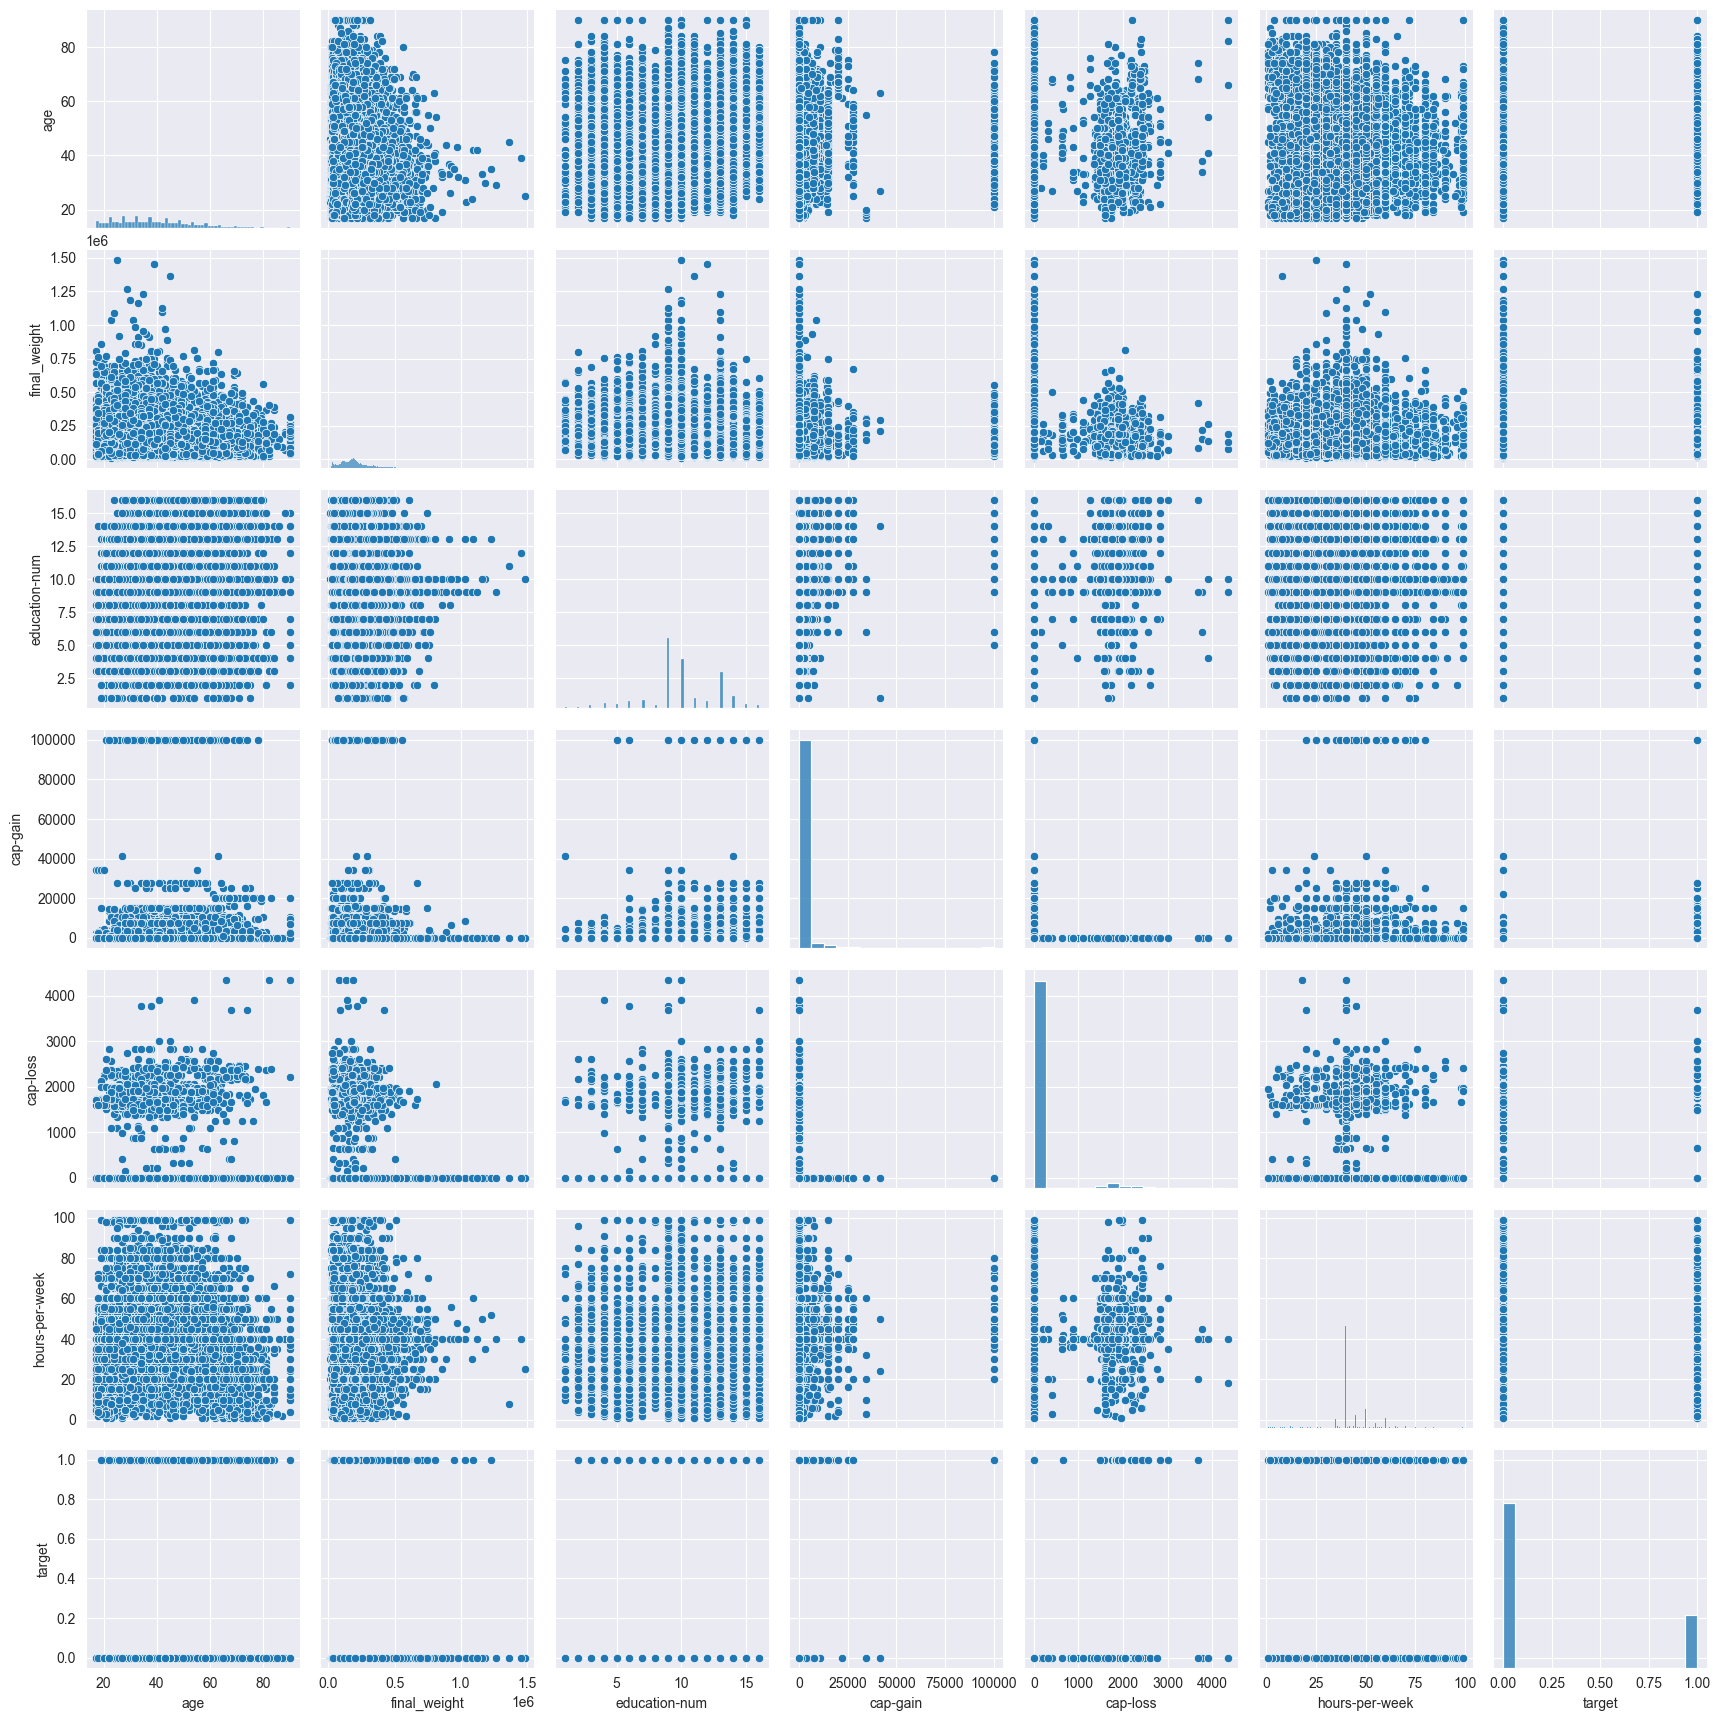

In [23]:
sns.pairplot(data=df_train[numerical_features_names + ['target']])

In [24]:
df_train[numerical_features_names + ['target']].corr(method='pearson')

,age,final_weight,education-num,cap-gain,cap-loss,hours-per-week,target
age,1.000000,-0.076447,0.036224,0.077676,0.057745,0.068515,0.234037
final_weight,-0.076447,1.000000,-0.043388,0.000429,-0.010260,-0.018898,-0.009502
education-num,0.036224,-0.043388,1.000000,0.122664,0.079892,0.148422,0.335272
cap-gain,0.077676,0.000429,0.122664,1.000000,-0.031639,0.078408,0.223336
cap-loss,0.057745,-0.010260,0.079892,-0.031639,1.000000,0.054229,0.150501
hours-per-week,0.068515,-0.018898,0.148422,0.078408,0.054229,1.000000,0.229658
target,0.234037,-0.009502,0.335272,0.223336,0.150501,0.229658,1.000000


In [25]:
df_train[numerical_features_names + ['target']].corr(method='spearman')

,age,final_weight,education-num,cap-gain,cap-loss,hours-per-week,target
age,1.000000,-0.077917,0.066199,0.124905,0.058433,0.142763,0.272896
final_weight,-0.077917,1.000000,-0.035828,-0.006032,-0.006910,-0.021882,-0.010798
education-num,0.066199,-0.035828,1.000000,0.119126,0.074730,0.167465,0.329787
cap-gain,0.124905,-0.006032,0.119126,1.000000,-0.066622,0.093316,0.278152
cap-loss,0.058433,-0.006910,0.074730,-0.066622,1.000000,0.059842,0.141015
hours-per-week,0.142763,-0.021882,0.167465,0.093316,0.059842,1.000000,0.269071
target,0.272896,-0.010798,0.329787,0.278152,0.141015,0.269071,1.000000


Из матрицы корреляции видно, что все числовые признаки довольно слабо, но коррелируют с таргетом, кроме final_weight.
При этом из анализа распределения final_weight мы знаем, что там присутствуют сильные выбросы, однако даже корреляция Спирмена почти равна нулю, хотя она менее чувствительна к выбросам. Делаем предположение, что final_weight не коррелирует с таргетом.

С анализом категориальных переменных можно поступить следующим образом - выполнить label-encoding и исследовать критерий согласия Хи^2 с таргетом.
При этом, предполагая, что с таким количеством категориальных переменных эффективно использовать CatBoost, вернемся к этому только в том случае, если CatBoost покажет низкую эффективность и потребуется использование других моделей. А отбор признаков можно будет провести с помощью feature_importance.

## 2.Baseline

Так как у нас присутствует дисбаланс классов в сторону 0, попробуем всегда предсказывать 0, и используем это в качестве бейзлайна.

In [26]:
df_train_cpy = df_train.copy()
target = df_train_cpy.pop('target')

In [27]:
X_train, X_val, y_train, y_val = train_test_split(df_train_cpy, target, test_size=0.3, random_state=RANDOM_STATE)
X_train

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country
1216,48,Self-emp-not-inc,243631.0,Some-college,10,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,7688.0,0.0,40,United-States
27970,31,Private,241360.0,Bachelors,13,Never-married,Sales,Not-in-family,White,Male,0.0,0.0,40,United-States
23079,50,Private,43764.0,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,15024.0,0.0,50,United-States
19680,22,Private,189888.0,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,45,United-States
19182,28,Private,107411.0,HS-grad,9,Never-married,Exec-managerial,Not-in-family,White,Female,0.0,0.0,45,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29835,38,Private,187983.0,Prof-school,15,Married-civ-spouse,Sales,Wife,White,Female,0.0,0.0,40,United-States
5392,63,Private,216413.0,Bachelors,13,Widowed,Adm-clerical,Not-in-family,White,Female,0.0,0.0,25,United-States
860,18,Private,216284.0,11th,7,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,20,United-States
15801,34,Private,242960.0,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,50,United-States


In [28]:
print(classification_report(y_true=y_val,y_pred=y_val * 0))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7405
           1       0.00      0.00      0.00      2357

    accuracy                           0.76      9762
   macro avg       0.38      0.50      0.43      9762
weighted avg       0.58      0.76      0.65      9762



C:\Users\Artem\PycharmProjects\WaveAccess_test_task\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Artem\PycharmProjects\WaveAccess_test_task\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Artem\PycharmProjects\WaveAccess_test_task\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Возьмем CatBoostClassifier и посмотрим как эта модель улучшит наш бейзлайн.

In [29]:
clf = CatBoostClassifier(iterations=500,
                         logging_level='Silent',
                         random_state=RANDOM_STATE)

In [30]:
clf.fit(X=X_train, y=y_train, cat_features=categorical_features_names)

In [31]:
y_pred = clf.predict(X_val)

In [32]:
print(classification_report(y_true=y_val,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7405
           1       0.78      0.65      0.71      2357

    accuracy                           0.87      9762
   macro avg       0.84      0.80      0.81      9762
weighted avg       0.87      0.87      0.87      9762



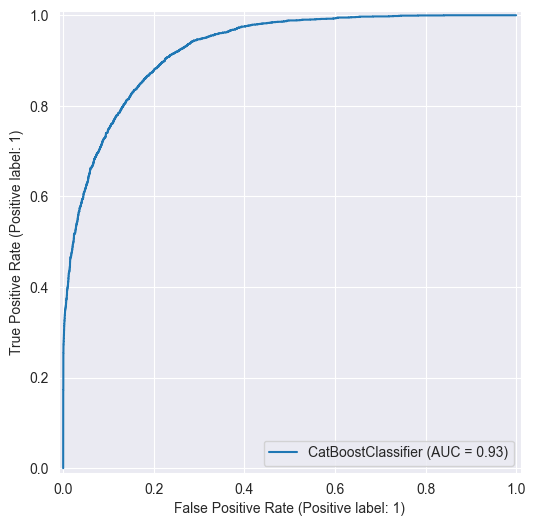

In [33]:
RocCurveDisplay.from_estimator(clf, X_val, y_val)

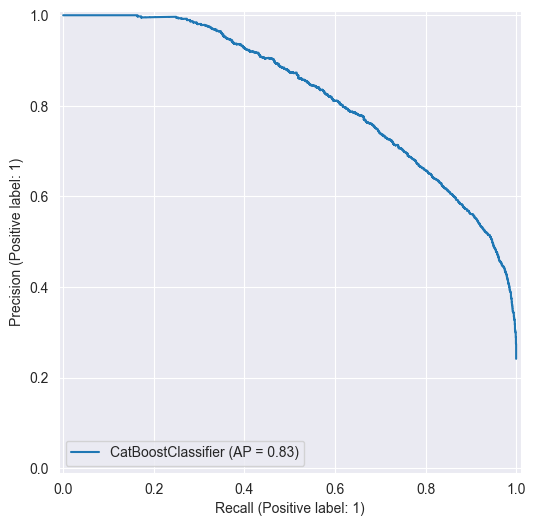

In [34]:
PrecisionRecallDisplay.from_estimator(clf, X_val, y_val)

## 3.Feature selection, feature engineering

Посмотрим на feature_importance нашей базовой модели CatBoostClassifier из прошлого пункта.

In [35]:
dict(zip(X_train.columns.tolist(), clf.get_feature_importance().tolist()))

{'age': 12.625863538806211,
 'workclass': 2.639048694033462,
 'final_weight': 3.7854414668941736,
 'education': 3.315858562615458,
 'education-num': 5.823519927451589,
 'marital-status': 6.41999365244262,
 'occupation': 7.144808788318719,
 'relationship': 20.56602287591348,
 'race': 0.929272773746949,
 'sex': 1.9602947578556822,
 'cap-gain': 18.35149712353756,
 'cap-loss': 7.276685688777475,
 'hours-per-week': 7.78588926949791,
 'native-country': 1.375802880108817}

Можно заметить, что native-country, race и sex имеют довольны низкие показатели, удалим их и обучим модель еще раз.

In [36]:
X_train.drop(columns=['race', 'sex', 'native-country'], inplace=True)
X_val.drop(columns=['race', 'sex', 'native-country'], inplace=True)

categorical_features_names = list(set(categorical_features_names) - {'race', 'sex', 'native-country'})
categorical_features_names

['occupation', 'marital-status', 'workclass', 'relationship', 'education']

In [37]:
clf.fit(X=X_train, y=y_train, cat_features=categorical_features_names)

In [38]:
y_pred = clf.predict(X_val)
print(classification_report(y_true=y_val,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7405
           1       0.78      0.64      0.70      2357

    accuracy                           0.87      9762
   macro avg       0.83      0.79      0.81      9762
weighted avg       0.86      0.87      0.86      9762



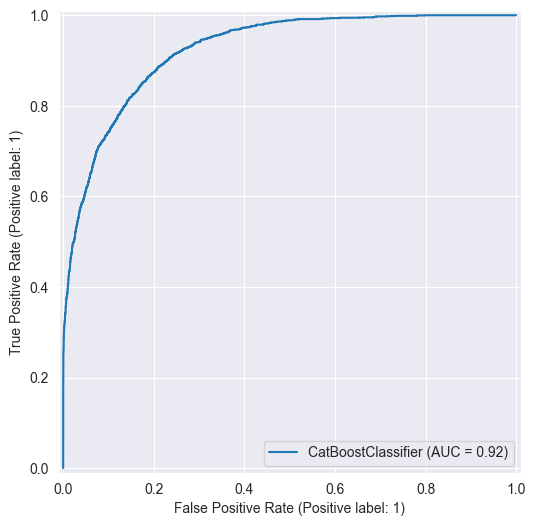

In [39]:
RocCurveDisplay.from_estimator(clf, X_val, y_val)

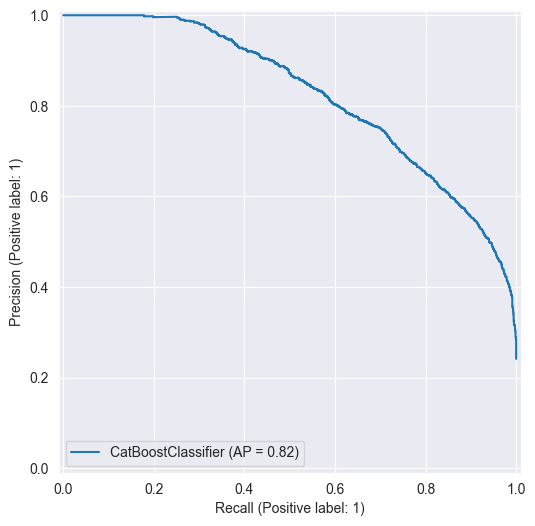

In [40]:
PrecisionRecallDisplay.from_estimator(clf, X_val, y_val)

Немного просел ROCAUC и AP, но в угоду упрощения модели и уменьшения времени обучения посчитаем, что это не критично.
Так как cap_gain и cap_loss представляют собой прибыль и потери, можно объединить их в один признак.

In [41]:
X_train['cap'] = X_train['cap-gain'] - X_train['cap-loss']
X_train.drop(columns=['cap-gain', 'cap-loss'], inplace=True)

X_val['cap'] = X_val['cap-gain'] - X_val['cap-loss']
X_val.drop(columns=['cap-gain', 'cap-loss'], inplace=True)

Снова обучим модель и посмотрим на метрики.

In [42]:
clf.fit(X=X_train, y=y_train, cat_features=categorical_features_names)

In [43]:
y_pred = clf.predict(X_val)
print(classification_report(y_true=y_val,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7405
           1       0.78      0.64      0.70      2357

    accuracy                           0.87      9762
   macro avg       0.84      0.79      0.81      9762
weighted avg       0.86      0.87      0.87      9762



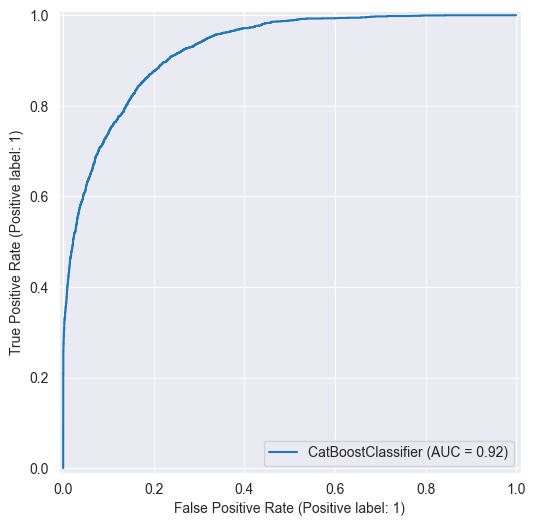

In [44]:
RocCurveDisplay.from_estimator(clf, X_val, y_val)

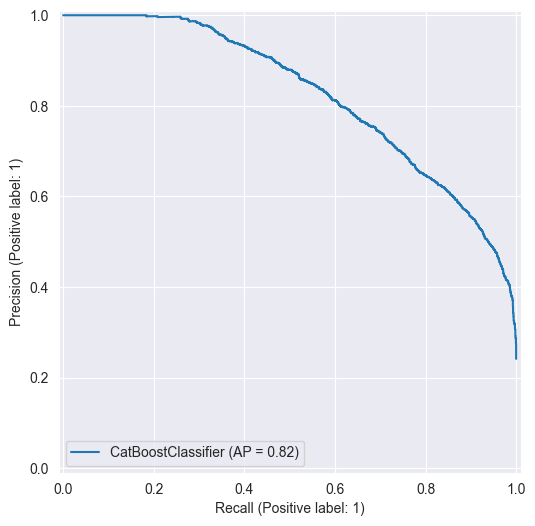

In [45]:
PrecisionRecallDisplay.from_estimator(clf, X_val, y_val)

In [46]:
dict(zip(X_train.columns.tolist(), clf.get_feature_importance().tolist()))

{'age': 13.814867564701308,
 'workclass': 3.507290951170297,
 'final_weight': 4.446029083883046,
 'education': 3.577484576947991,
 'education-num': 6.982554796957064,
 'marital-status': 6.977727050972777,
 'occupation': 8.043529068699083,
 'relationship': 17.385078383414882,
 'hours-per-week': 8.684741441084098,
 'cap': 26.58069708216933}

Метрики немного выросли, и мы упростили модель.

## 4. Fine-tuning

Выполним более точный подбор параметров модели с помощью grid search, а также используем кросс-валидацию.

In [47]:
clf = CatBoostClassifier(cat_features=categorical_features_names,
                         logging_level='Silent',
                         random_state=RANDOM_STATE)
grid = {'iterations': [500, 1000],
        'depth': [5, 7, 9],
        'l2_leaf_reg': [3, 5, 7]}
grid_search_result = clf.grid_search(grid,
                                     cv=5,
                                     X=X_train,
                                     y=y_train,
                                     plot=False,
                                     verbose=1)

0:	loss: 0.2892037	best: 0.2892037 (0)	total: 11.1s	remaining: 3m 9s
1:	loss: 0.2894298	best: 0.2892037 (0)	total: 22.6s	remaining: 3m
2:	loss: 0.2905020	best: 0.2892037 (0)	total: 34.4s	remaining: 2m 52s
3:	loss: 0.2860278	best: 0.2860278 (3)	total: 57.1s	remaining: 3m 19s
4:	loss: 0.2856563	best: 0.2856563 (4)	total: 1m 23s	remaining: 3m 36s
5:	loss: 0.2861026	best: 0.2856563 (4)	total: 1m 46s	remaining: 3m 32s
6:	loss: 0.2868642	best: 0.2856563 (4)	total: 2m 1s	remaining: 3m 10s
7:	loss: 0.2880485	best: 0.2856563 (4)	total: 2m 15s	remaining: 2m 49s
8:	loss: 0.2891433	best: 0.2856563 (4)	total: 2m 30s	remaining: 2m 30s
9:	loss: 0.2839493	best: 0.2839493 (9)	total: 3m	remaining: 2m 24s
10:	loss: 0.2840734	best: 0.2839493 (9)	total: 3m 30s	remaining: 2m 13s
11:	loss: 0.2850964	best: 0.2839493 (9)	total: 4m 2s	remaining: 2m 1s
12:	loss: 0.2863495	best: 0.2839493 (9)	total: 4m 22s	remaining: 1m 41s
13:	loss: 0.2886384	best: 0.2839493 (9)	total: 4m 42s	remaining: 1m 20s
14:	loss: 0.287996

In [48]:
y_pred = clf.predict(X_val)
print(classification_report(y_true=y_val,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7405
           1       0.78      0.64      0.70      2357

    accuracy                           0.87      9762
   macro avg       0.84      0.79      0.81      9762
weighted avg       0.87      0.87      0.87      9762



In [49]:
clf.get_params()

{'logging_level': 'Silent',
 'random_state': 42,
 'cat_features': ['occupation',
  'marital-status',
  'workclass',
  'relationship',
  'education'],
 'depth': 7,
 'l2_leaf_reg': 3,
 'iterations': 1000}

Метрики немного снизились, при этом мы использовали кросс-валидацию, а значит полученные параметры являются более объективными.
Обучим эту модель на всей имеющейся выборке и сделаем предсказание.

In [50]:
clf = CatBoostClassifier(cat_features=categorical_features_names,
                         logging_level='Silent',
                         random_state=RANDOM_STATE,
                         depth=7,
                         l2_leaf_reg=3,
                         iterations=1000)

# Так как мы преобразовывали уже сплитованный трейн,
# просто объединим датасеты обратно
clf.fit(X=pd.concat([X_train, X_val]),
        y=pd.concat([y_train, y_val]))

## 5. Test prediction

Выполним обработку test датасета аналогично train.

In [51]:
names = ['age', 'workclass', 'final_weight', 'education', 'education-num', 'marital-status','occupation',
         'relationship', 'race','sex', 'cap-gain', 'cap-loss', 'hours-per-week', 'native-country']
df_test = pd.read_csv('data/test_empty.txt', names=names, index_col=False, sep=',', skipinitialspace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16283 entries, 0 to 16282
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             16283 non-null  object 
 1   workclass       16282 non-null  object 
 2   final_weight    16282 non-null  float64
 3   education       16282 non-null  object 
 4   education-num   16282 non-null  float64
 5   marital-status  16282 non-null  object 
 6   occupation      16282 non-null  object 
 7   relationship    16282 non-null  object 
 8   race            16282 non-null  object 
 9   sex             16282 non-null  object 
 10  cap-gain        16282 non-null  float64
 11  cap-loss        16282 non-null  float64
 12  hours-per-week  16282 non-null  float64
 13  native-country  16282 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.7+ MB


Можем заметить, что аналогично обучающей выборке, здесь присутствует строка с NaN значениями.

In [52]:
df_test[df_test['workclass'].isnull()]

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country
12513,fssafsa121321ewd1231e2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выполним приведение типов и посмотрим на значения.

In [53]:
df_test[categorical_features_names] = df_test[categorical_features_names].astype('category')
df_test['hours-per-week'] = pd.to_numeric(df_train['hours-per-week'])
df_test['education-num'] = pd.to_numeric(df_train['education-num'])
df_test['age'] = pd.to_numeric(df_train['age'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16283 entries, 0 to 16282
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             16277 non-null  float64 
 1   workclass       16282 non-null  category
 2   final_weight    16282 non-null  float64 
 3   education       16282 non-null  category
 4   education-num   16277 non-null  float64 
 5   marital-status  16282 non-null  category
 6   occupation      16282 non-null  category
 7   relationship    16282 non-null  category
 8   race            16282 non-null  object  
 9   sex             16282 non-null  object  
 10  cap-gain        16282 non-null  float64 
 11  cap-loss        16282 non-null  float64 
 12  hours-per-week  16277 non-null  float64 
 13  native-country  16282 non-null  object  
dtypes: category(5), float64(6), object(3)
memory usage: 1.2+ MB


Заметим, что некоторые значения во время приведения типов превратились в NaN, что объясняется наличием ошибок в тестовой выборке.
Таких записей менее 0.05%, поэтому без риска получить большие потери в точности, заполним их при помощи forward fill.

In [54]:
df_test.ffill(inplace=True)

И обработаем признаки аналогично трейну.

In [55]:
df_test['cap'] = df_test['cap-gain'] - df_test['cap-loss']
df_test.drop(columns=['race', 'sex', 'native-country', 'cap-gain', 'cap-loss'], inplace=True)

Итоговое предсказание:

In [56]:
test_pred = clf.predict(df_test)
test_pred

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [57]:
#  Сохраним в файл
pd.DataFrame(test_pred).to_csv('prediction.txt', header=False, index=False)